In [ ]:
!pip install pyyaml==5.4.1
!pip install darts

In [1]:
import time
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
import darts
from darts import TimeSeries
from darts.models import KalmanFilter, RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.utils import timeseries_generation as tg
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Sampling Rate
The problem: 
As can be seen below, there are gaps in patient cgm data. This could be because a CGM was disconected or for some other reason. Additionally, the data is close to being sampled at 5 minutes for every sample, but as can be seen in the following plot, there are definitely times when the sample rate for the data is not normalized or constant. 

Solution: 
1. First, to ensure high quality data, find the longest Contiguous chunk of samples, per patient, for  which all samples are closer than 1.5 hours together in time. 

2. Second, re-sample the data at 30 minute intervals, performing a spline interpolation where necessary. 

For more on how this was done please see `./PreProcessResample.ipynb`


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Change this as needed locally or in colab
data_relative_path = "/content/drive/MyDrive/Colab Notebooks/glucose_prediction/data"

In [5]:
# helper constants
MINUTES_PER_DAY = 1440.0

patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]

In [4]:
# helper functions
# TODO: refactor this to a module in ./scripts
def save_df_to_hdf(df, patient_id, file_name_ptrn, **kwarg):
    df.to_hdf(file_name_ptrn.format(patient_id), 'df{:02d}'.format(patient_id), **kwarg)
    print(f"...saved {patient_id} to hdf...") 

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = {}
  for i, (patient_id, df) in enumerate(patient_dfs.items()): 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries[patient_id] = individual_patient_timeseries
  return all_patient_timeseries

def get_timestamp_patient_dfs(): 
  timestamp_patient_dfs = {}
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f"{data_relative_path}/timestamp/patient_df_{patient_id_string}.h5")  
    timestamp_patient_dfs[patient_id] = df
  return timestamp_patient_dfs

def get_longest_subsequence_as_df(original_df, max_diff_hours = 1.5): 
  """
  considers only samples that are less than max_diff_hours hours apart by adding an id to each element which represents that contiguous subsection
  idea is adapted from: https://stackoverflow.com/questions/59724691/finding-the-longest-sequence-of-dates-in-a-dataframe
  """
  df_copy = original_df.copy()
  df_copy['mask'] = 1
  df_copy['DeviceDateTime_temp'] = df_copy.index

  df_copy.loc[df_copy['TotalInternalHours_Diff'] < max_diff_hours, 'mask'] = 0 
  df_copy['mask'] = df_copy['mask'].cumsum()
  # get the DeviceDateTime indicies of the subsequence with the highest count. 
  res = df_copy.loc[df_copy['mask'] == df_copy['mask'].value_counts().idxmax()]
  res = res.drop(columns=['mask', 'DeviceDateTime_temp'])
  return res

In [10]:
patient_cgm_dfs = get_timestamp_patient_dfs()

As can be seen below, we have gaps, in time, in our data. 
---



<AxesSubplot:title={'center':'Patient 184 - Difference in time between sequential data vs time (minutes)'}, xlabel='TotalDeviceMinutes', ylabel='TotalDeviceHours_Diff'>

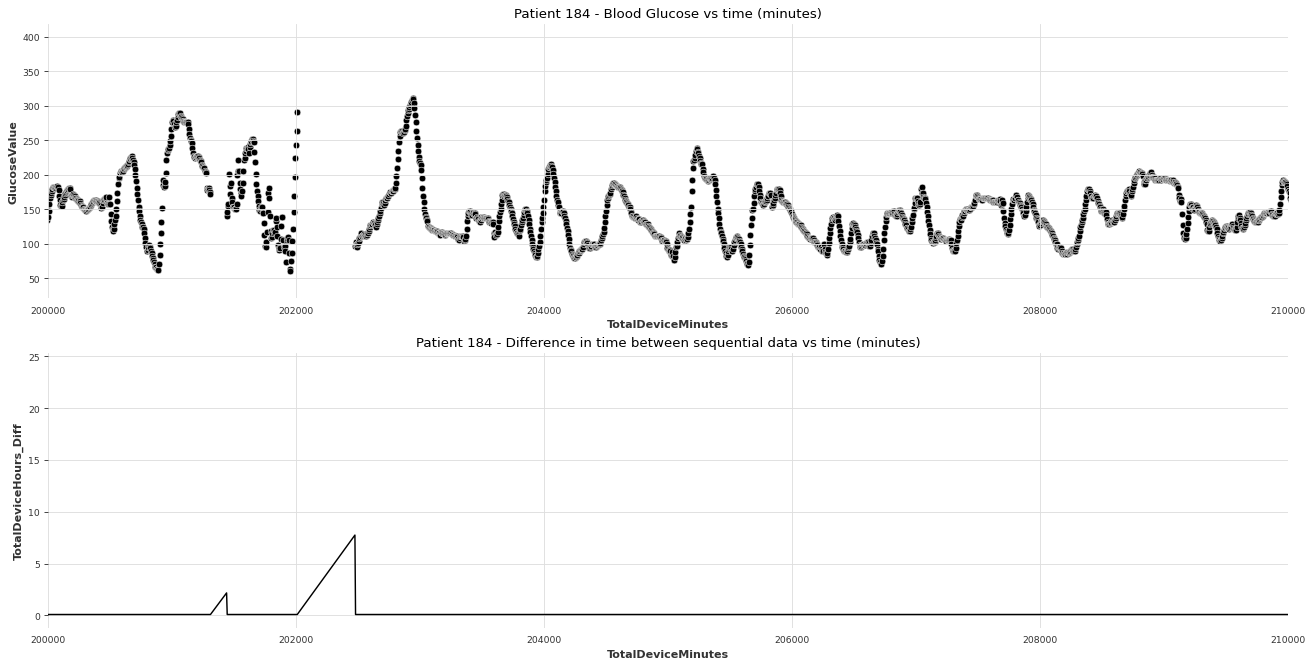

In [12]:
# There are big gaps!
df_example_timestamp_added_pt184 = pd.read_hdf(f"{data_relative_path}/timestamp/patient_df_184.h5")  
df_example_timestamp_added_pt184.head()
df_example_timestamp_added_pt184['TotalDeviceHours_Diff'] = abs(df_example_timestamp_added_pt184['TotalDeviceMinutes'].diff() / 60)

fig, axes = plt.subplots(2,1, figsize=(20,10), dpi=80)
axes[0].set_title("Patient 184 - Blood Glucose vs time (minutes)")
axes[0].set_xlim(200000, 210000)
sns.scatterplot(data=df_example_timestamp_added_pt184, x="TotalDeviceMinutes", y="GlucoseValue", ax=axes[0])

axes[1].set_title("Patient 184 - Difference in time between sequential data vs time (minutes)")
axes[1].set_xlim(200000, 210000)
sns.lineplot(data=df_example_timestamp_added_pt184, x="TotalDeviceMinutes", y="TotalDeviceHours_Diff", ax=axes[1])

<AxesSubplot:title={'center':'Patient 184 - Difference in time between sequential data vs time (minutes)'}, xlabel='TotalDeviceMinutes', ylabel='TotalDeviceHours_Diff'>

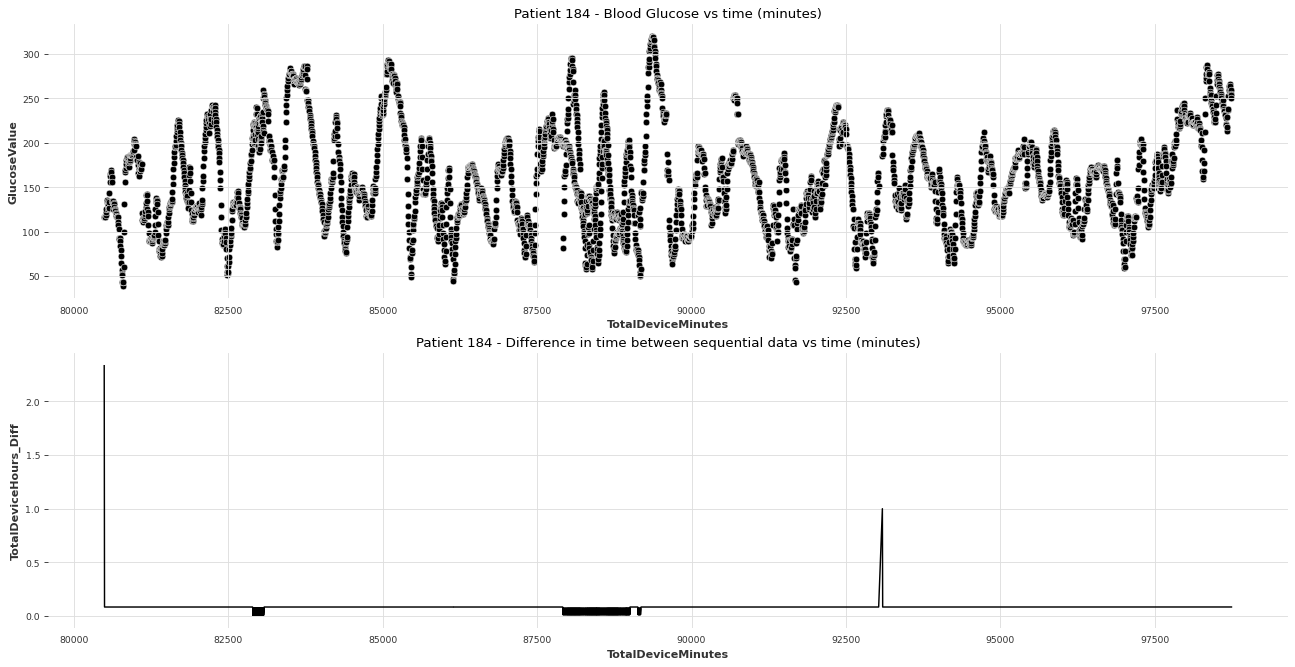

In [13]:
# test get the longest contiguous subsequence 
pt184_longest_subsequence = get_longest_subsequence_as_df(df_example_timestamp_added_pt184)
df_example_timestamp_added_pt184['TotalDeviceHours_Diff'] = abs(df_example_timestamp_added_pt184['TotalDeviceMinutes'].diff() / 60)

fig, axes = plt.subplots(2,1, figsize=(20,10), dpi=80)
axes[0].set_title("Patient 184 Longest Subsequence - Blood Glucose vs time (minutes)")
sns.scatterplot(data=pt184_longest_subsequence, x="TotalDeviceMinutes", y="GlucoseValue", ax=axes[0])
axes[1].set_title("Patient 184 - Difference in time between sequential data vs time (minutes)")
sns.lineplot(data=pt184_longest_subsequence, x="TotalDeviceMinutes", y="TotalDeviceHours_Diff", ax=axes[1])

As seen above, In our longest subsequence, there are NO timegaps greater than 1.5 hours

In [ ]:
# get the longest subsequence, resample at 30 minute intervals, and save the results for each patient. 
patient_cgm_dfs_resampled = {}
for i, (patient_id, df) in enumerate(patient_cgm_dfs.items()): 
  df_longest_subsequence = get_longest_subsequence_as_df(df)
  if(len(df_longest_subsequence) < 500): 
    print(f"ignoring {patient_id}, length of longest subsequence was {len(df_longest_subsequence)}")
    continue
  df_longest_subsequence = df_longest_subsequence.drop(
    columns=[
        'ParentHDeviceUploadsID',
        'RecID', 
        'PtID',
        'DeviceTm',
        'DexInternalDtTmDaysFromEnroll',
        'DexInternalTm',
        'RecordType', 
        'TotalDeviceHours_Diff',
        'SiteId',
        'DeviceDtTmDaysFromEnroll',
        'SiteID'],
    errors="ignore")
  last_sample_offset = df_longest_subsequence.index[-1]
  df_resampled = df_longest_subsequence.resample('30T', label='right', closed='right', offset=f"{(last_sample_offset.minute*60) + last_sample_offset.second}S").mean().interpolate(method="spline", order=1)
  df_resampled = df_resampled.sort_values(by='TotalDeviceMinutes', ascending=True, na_position='first')
  patient_cgm_dfs_resampled[patient_id] = df_resampled
  print(f'saving resampled patient: {patient_id}')
  save_df_to_hdf(df_resampled, patient_id, r'/content/drive/MyDrive/Colab Notebooks/glucose_prediction/data/resampled/patient_df_{:02}.h5', format='t',
                 complib='blosc', complevel=5)


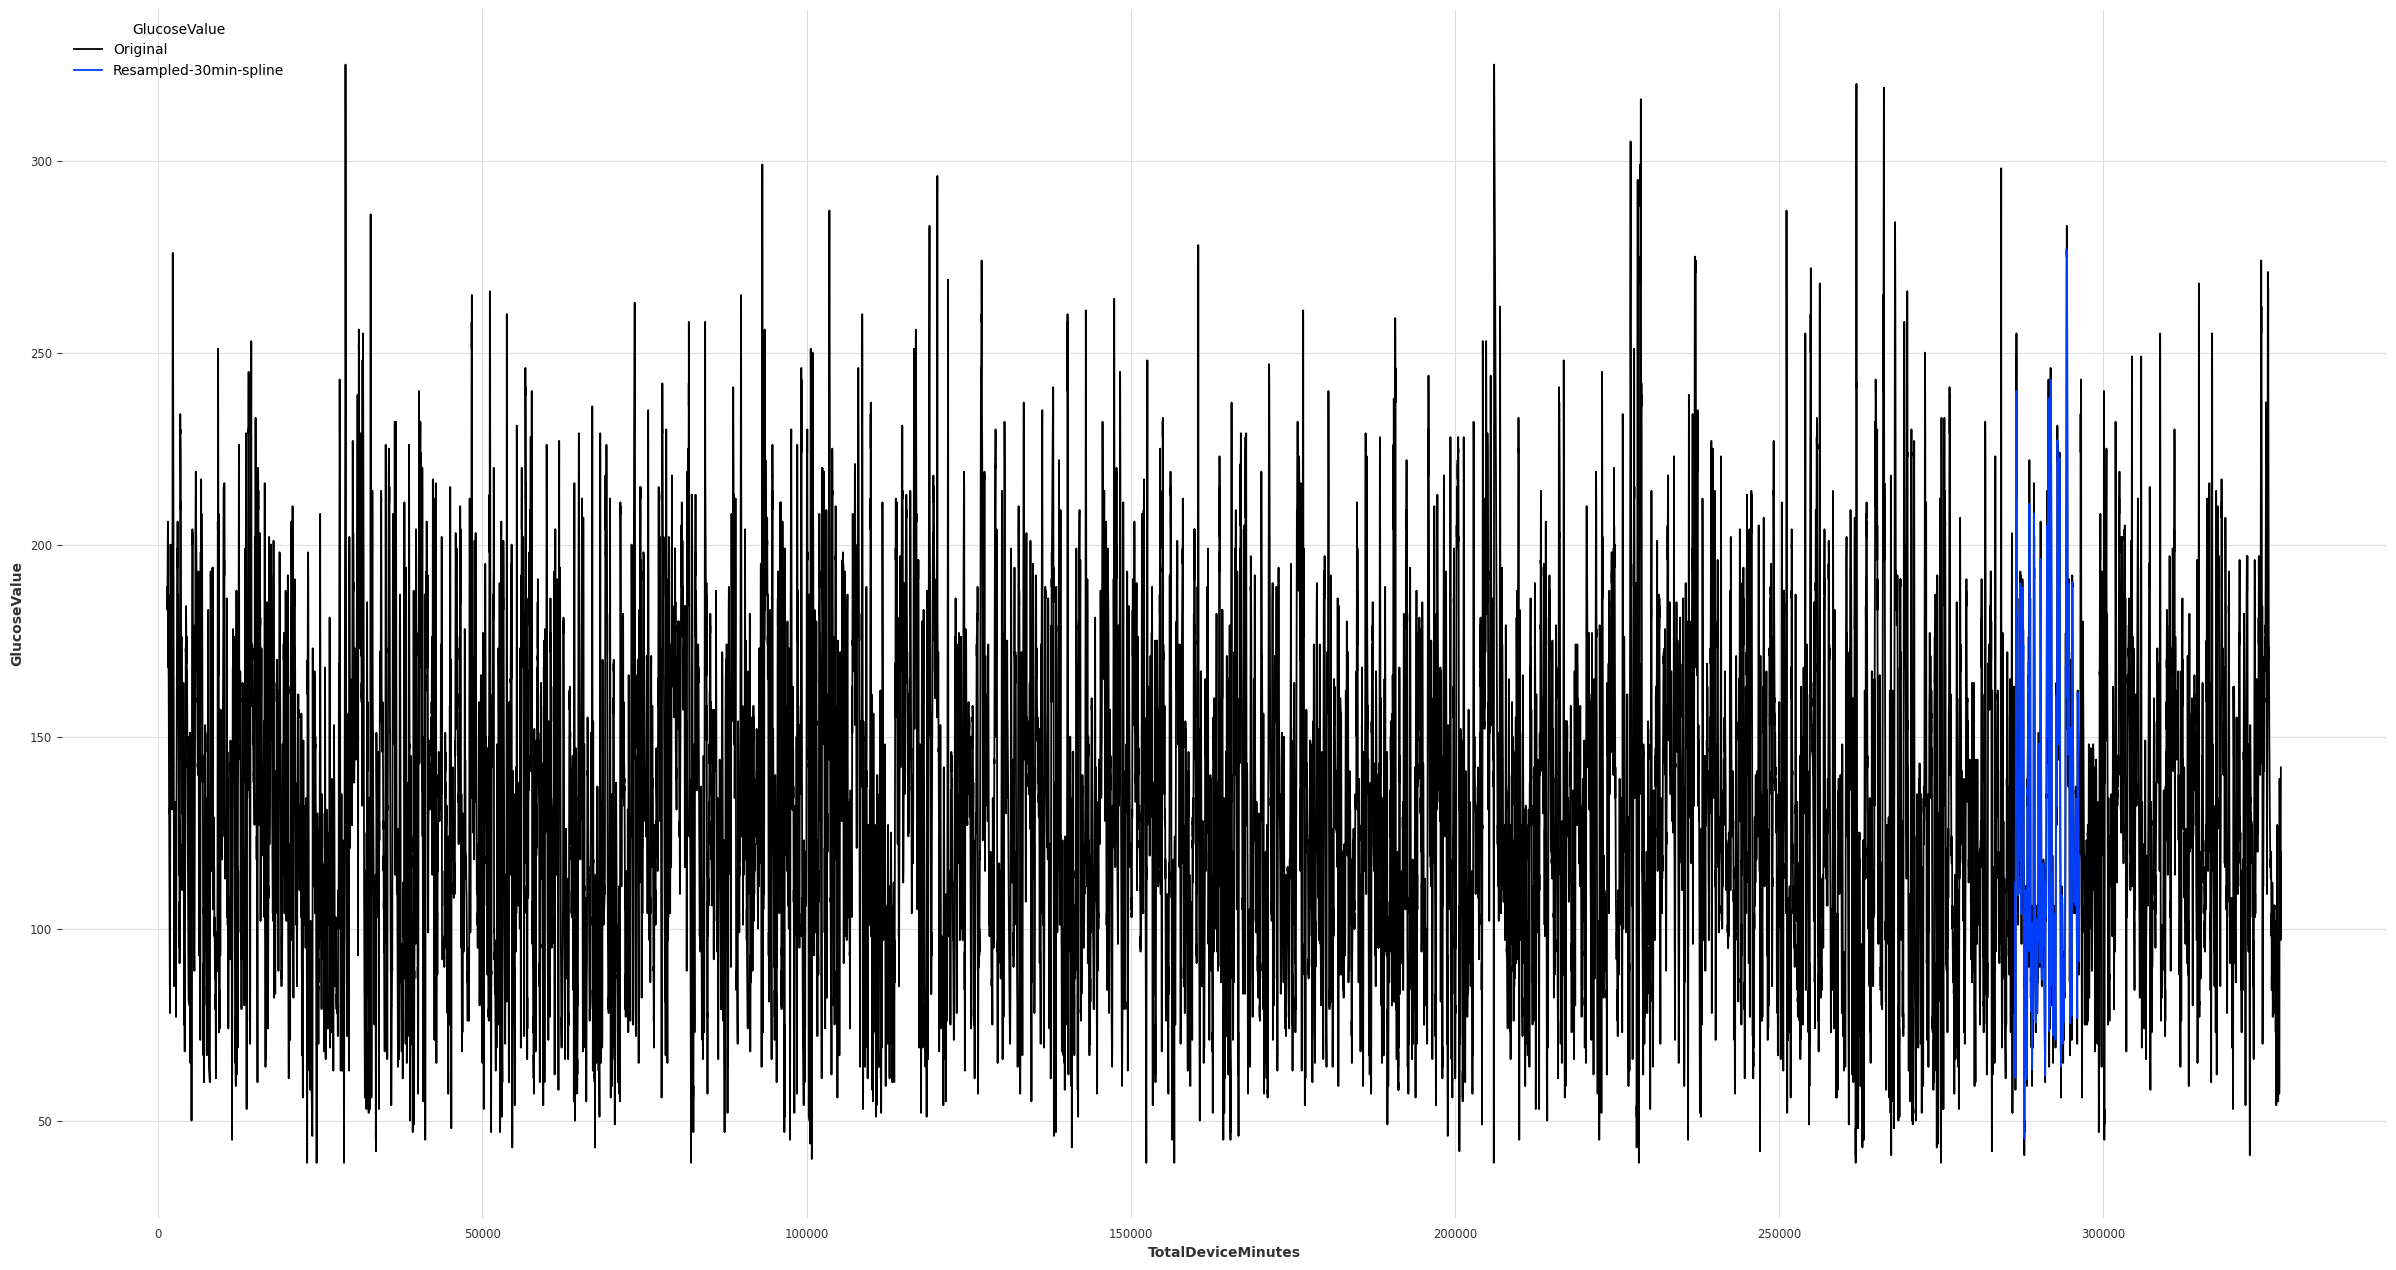

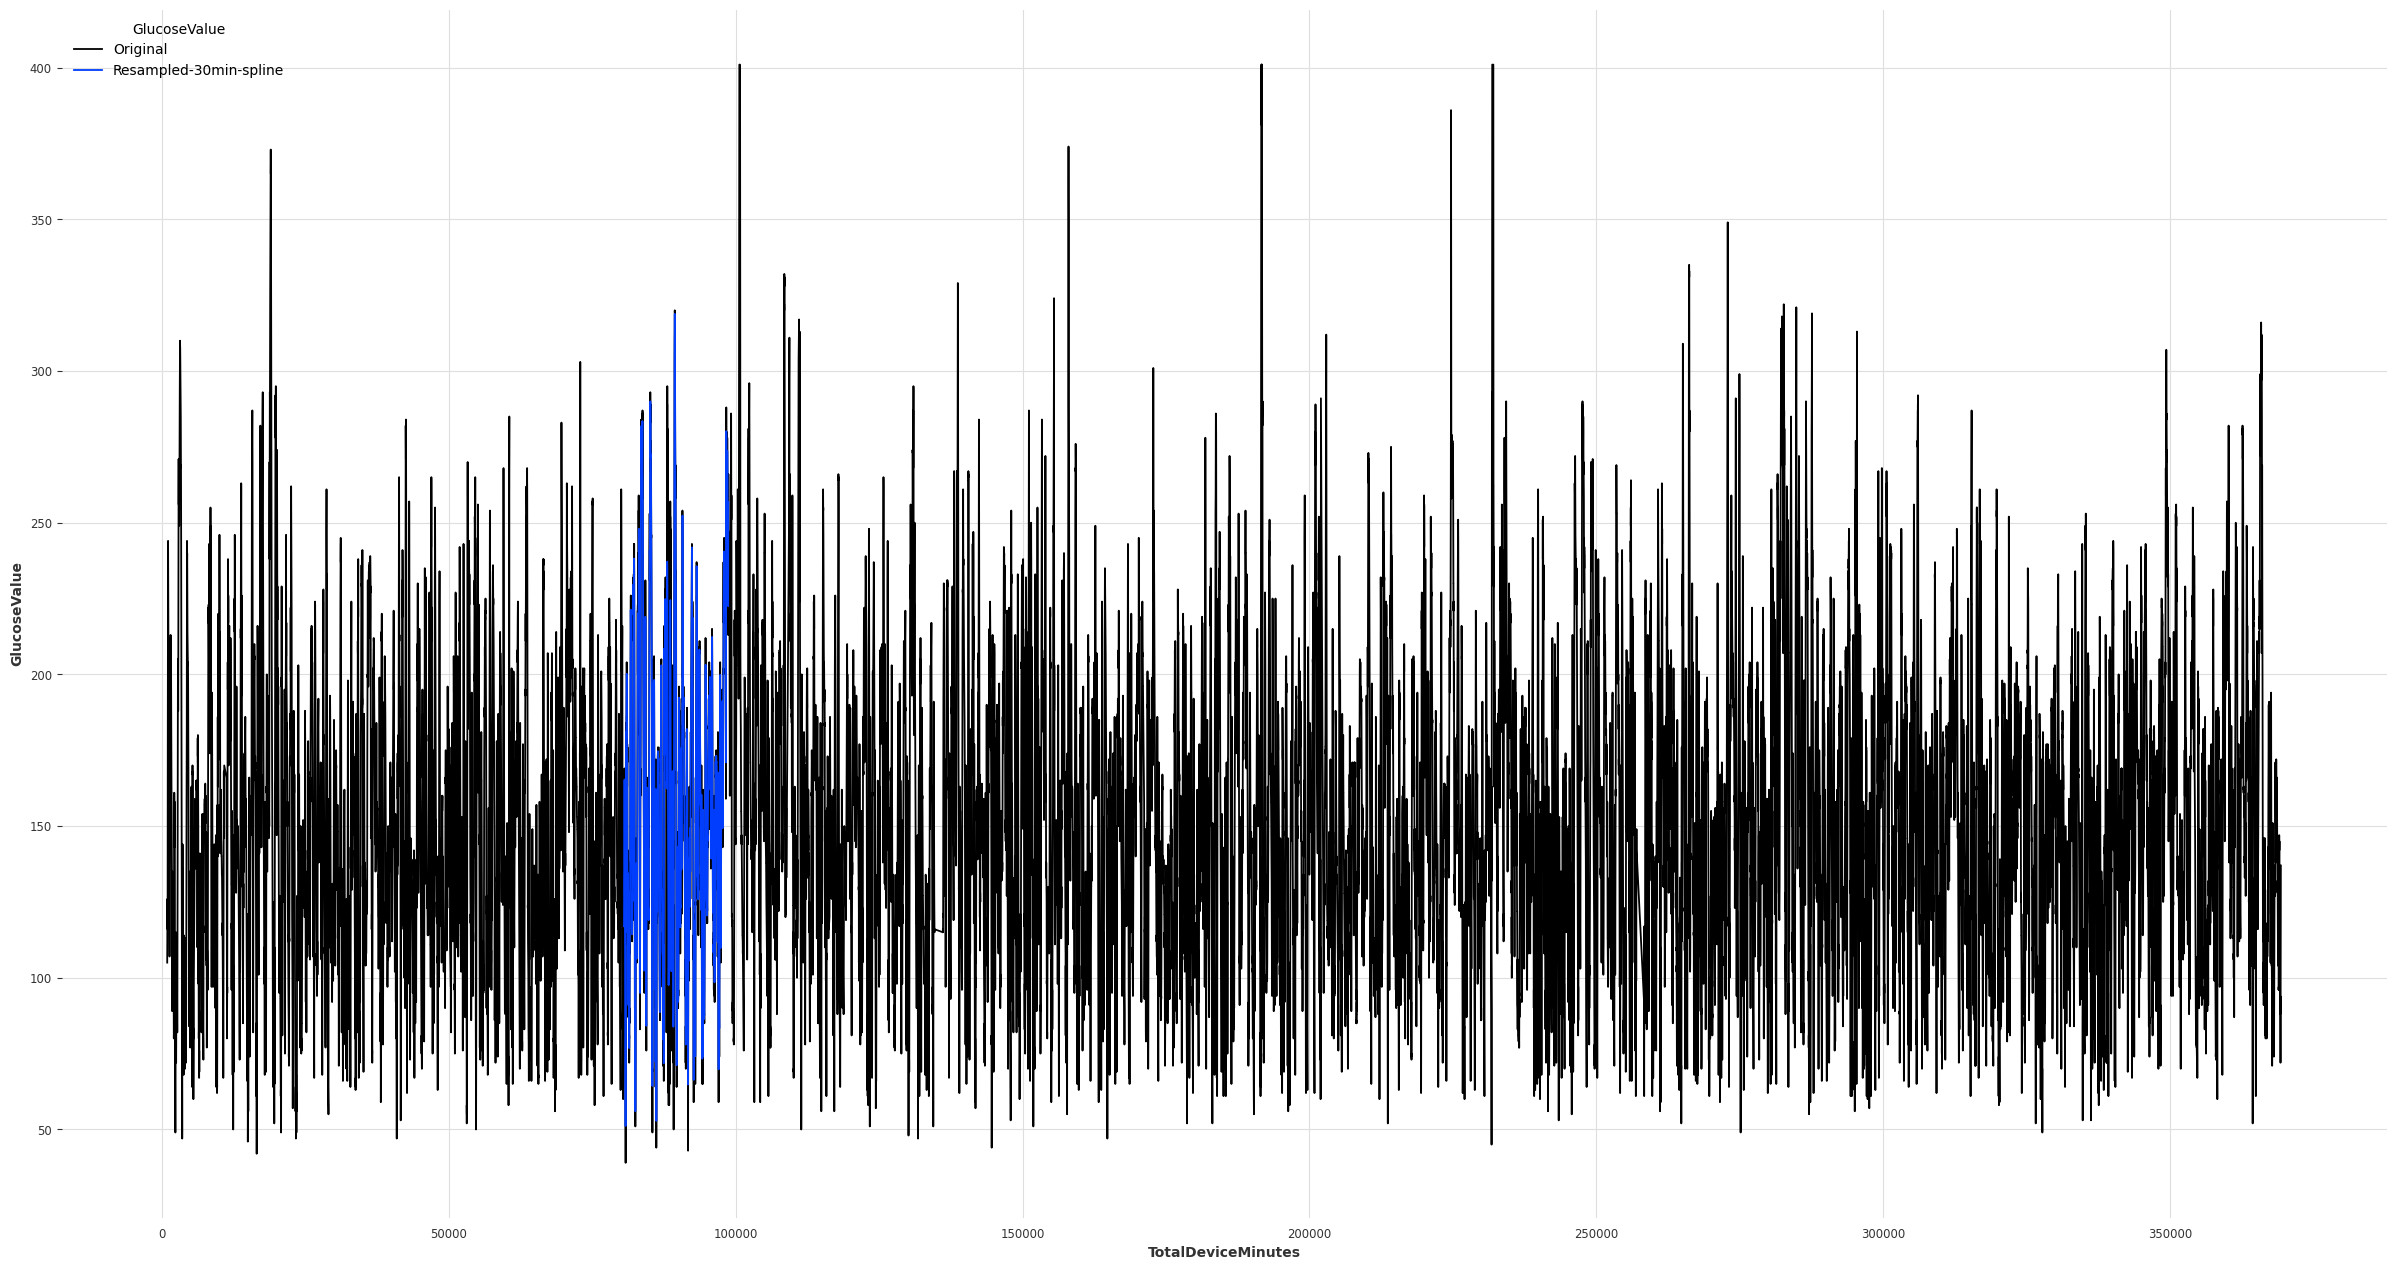

In [36]:
# examples of the smoothed data from resampling...
fig, ax = plt.subplots(1,1, figsize=(30,16), dpi=100)
df_183_filtered_length = len(patient_cgm_dfs_resampled[183])
# ax.set_xlim(df_183_filtered_length - 500, df_183_filtered_length)
sns.lineplot(data=patient_cgm_dfs[183], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
sns.lineplot(data=patient_cgm_dfs_resampled[183], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Resampled-30min-spline'])

fig, ax = plt.subplots(1,1, figsize=(30,16), dpi=100)
df_184_filtered_length = len(patient_cgm_dfs_resampled[184])
# ax.set_xlim(df_184_filtered_length - 500, df_184_filtered_length)
sns.lineplot(data=patient_cgm_dfs[184], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
sns.lineplot(data=patient_cgm_dfs_resampled[184], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Resampled-30min-spline'])


As we can see above, the longest subsequences are selected from the original timeseries data. 

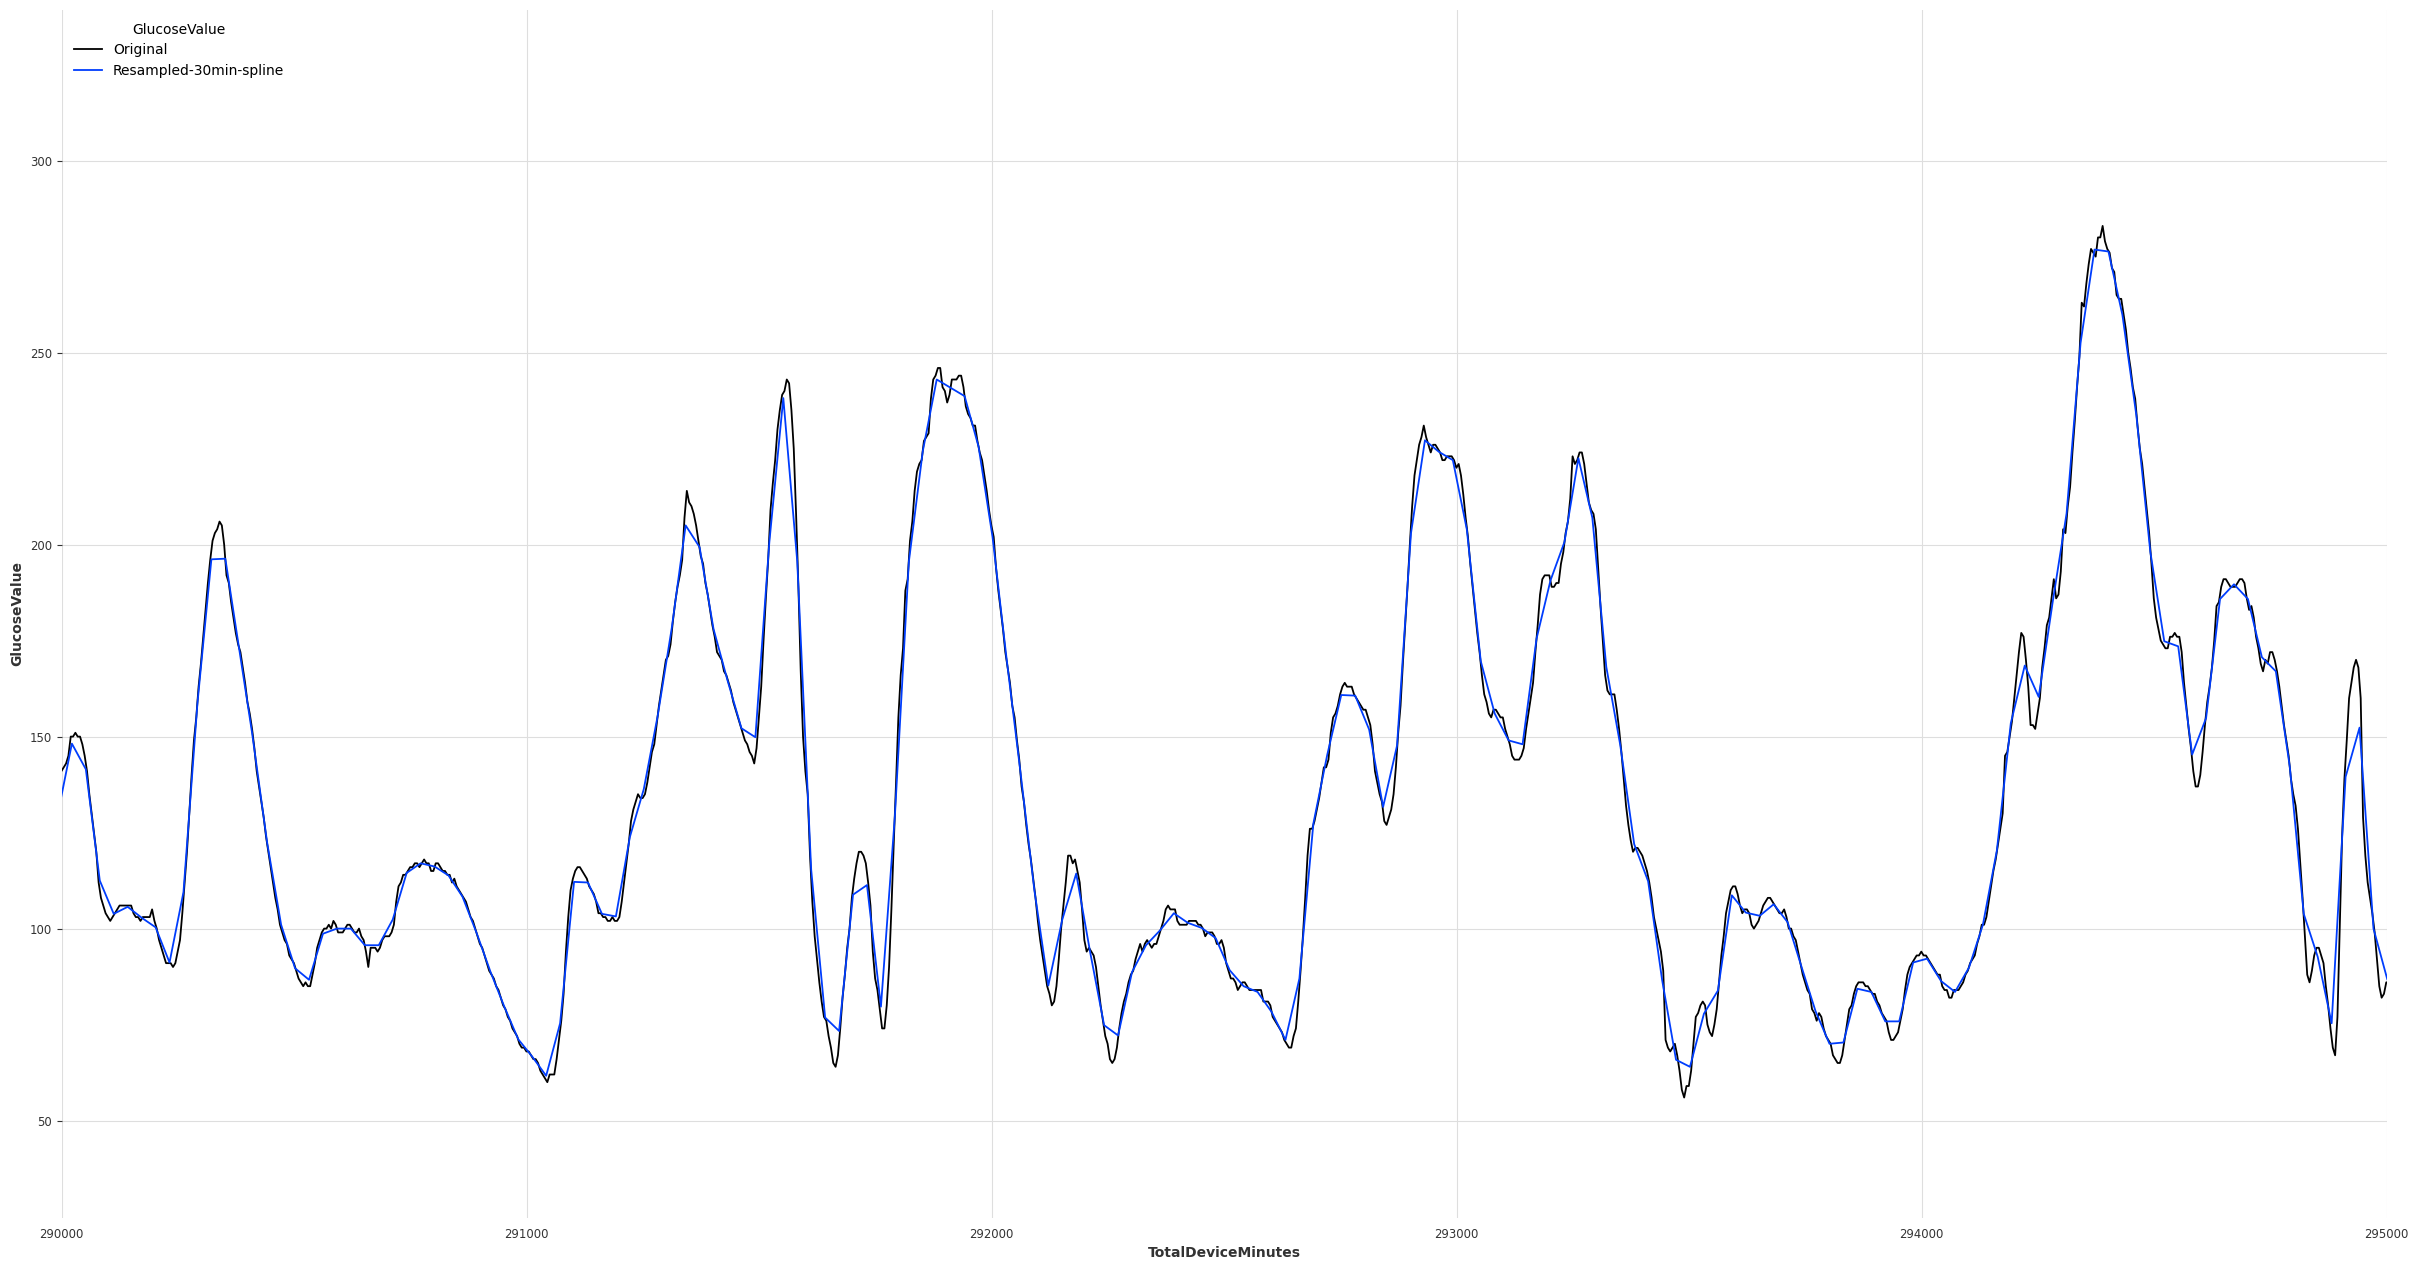

In [39]:
# examples of the smoothed data from resampling...
fig, ax = plt.subplots(1,1, figsize=(30,16), dpi=100)
ax.set_xlim(295000-5000, 295000)
sns.lineplot(data=patient_cgm_dfs[183], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
sns.lineplot(data=patient_cgm_dfs_resampled[183], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Resampled-30min-spline'])


We can see that the 30 min resampled data with spline interploation essentially smooths the data slightly. This shouldn't be too much of a problem and might even benefit our predictions later. 

<AxesSubplot:title={'center':'Patient 184 - Difference in time between sequential data vs time (minutes)'}, xlabel='TotalDeviceMinutes', ylabel='TotalDeviceHours_Diff'>

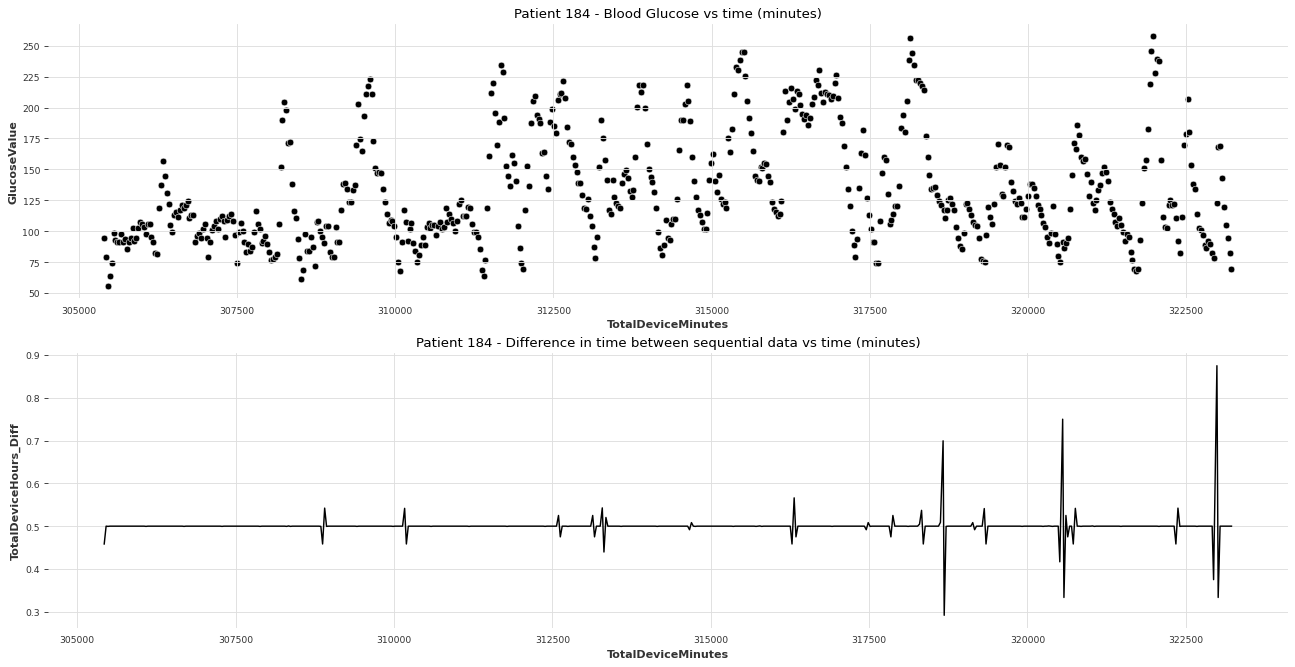

In [22]:
pt184_copy = patient_cgm_dfs_resampled[184].copy()
pt184_copy['TotalDeviceHours_Diff'] = abs(pt184_copy['TotalDeviceMinutes'].diff() / 60)

fig, axes = plt.subplots(2,1, figsize=(20,10), dpi=80)
axes[0].set_title("Patient 184 - Blood Glucose vs time (minutes)")
sns.scatterplot(data=pt184_copy, x="TotalDeviceMinutes", y="GlucoseValue", ax=axes[0])

axes[1].set_title("Patient 184 - Difference in time between sequential data vs time (minutes)")
sns.lineplot(data=pt184_copy, x="TotalDeviceMinutes", y="TotalDeviceHours_Diff", ax=axes[1])

In the above plot we an see the longest subsequence with the differenc in sequential time. Note that there are no large gaps between any timepoints. 

Text(0.5, 0, 'Frequency (Hz)')

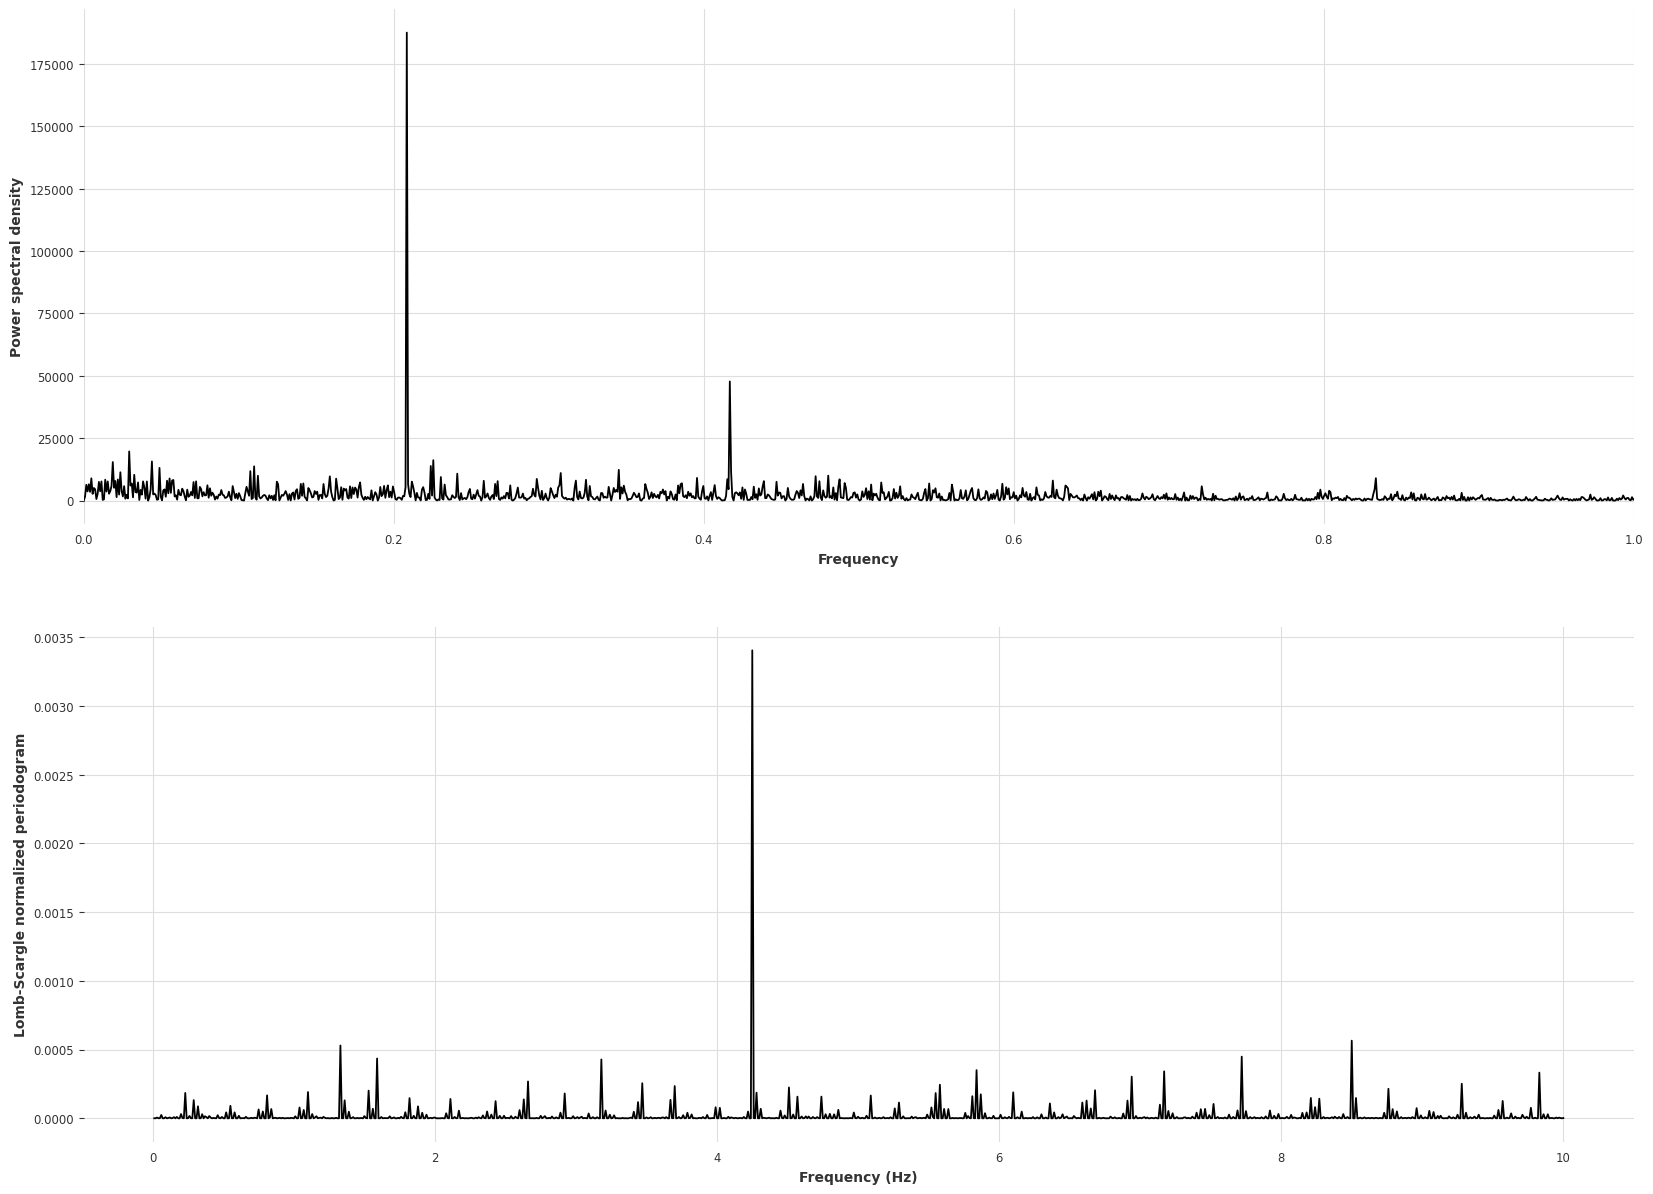

In [ ]:
import signal 
fig, ax_list = plt.subplots(2,1, figsize=(20, 15), dpi=100)

input_signal = pt184_copy['GlucoseValue'].values
t_steps = pt184_copy.index.values

# fig 3
ax=ax_list[0]
f, Pxx_den = periodogram(input_signal, fs=10)
ax.set_xlim(0, 1) # keep our periodogram between 0 and nyquist 
ax.plot(f, Pxx_den)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency')


# fig 4
# Plot Lomb-Scargle spectrogram of input signal
ax = ax_list[1]
f = np.linspace(0.01, 10, 1000)
pgram = lombscargle(t_steps, input_signal, f, normalize=True)
ax.plot(f, pgram)
ax.set_ylabel("Lomb-Scargle normalized periodogram")
ax.set_xlabel('Frequency (Hz)')
# plt.savefig('periodogram_plot_evendata.png', dpi=300, bbox_inches='tight')

We can see the dominant frequency or possible seasonality is roughly .21 HZ (at a 30min sample rate). This correlates to ~3 hours, which is probably about the amount of time between patient 184's meals. 

In [ ]:
# Note: for now we are training the kalman filter on the first 5,000 cgm entries for each patient. 
# we cannot train on all data, the kalman filter takes too long to train.
# due to serial correlation, and heteroskedascitity this might be problematic. 
# TODO: future goal to sample random contiguous subsections of each patient array. 
# RUN THIS ONLY IF THERE IS TIME! it is slow and is 'nice to have' not part of the MVP
patient_cgm_dfs_filtered = {}
all_patient_timeseries_resampled = get_all_resampled_patient_timeseries(patient_cgm_dfs_resampled, "GlucoseValue")
for i, (patient_id, patient_timeseries) in enumerate(all_patient_timeseries_resampled.items()): 
  print(i)
  kf = KalmanFilter(dim_x=1)
  kf.fit(patient_timeseries.head(5000), torch_device_str="cuda")
  y_filtered = kf.filter(patient_timeseries)
  resampled_patient_df_copy = patient_cgm_dfs_resampled[patient_id].copy()
  resampled_patient_df_copy['GlucoseValue_kalman_filtered'] = y_filtered.pd_series()
  patient_cgm_dfs_filtered[patient_id] = resampled_patient_df_copy
  save_df_to_hdf(resampled_patient_df_copy, patient_id, r'/content/drive/MyDrive/Colab Notebooks/data/filtered/patient_df_{:02}.h5', format='t',
                complib='blosc', complevel=5)

In [ ]:
pt184_copy = patient_cgm_dfs_filtered[184].copy()
plt.figure(figsize=(30,16))
fig, ax = plt.subplots(figsize=(30,16))
sns.lineplot(data=pt184_copy.head(200), x="TotalDeviceMinutes", y="GlucoseValue", ax=ax)
sns.lineplot(data=pt184_copy.head(200), x="TotalDeviceMinutes", y="GlucoseValue_kalman_filtered", ax=ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Kalman Filtered order-2'])